<a href="https://colab.research.google.com/github/sidvsukhi/Text-Summarization-of-T-C/blob/main/Project_ContractNLI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 1- Summarizing Terms and Conditions
### Group No.: 23

## Importing Libraries and Loading Dataset

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/siddhantsukhatankar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Declaring constants
DATA_DIR = '/Users/siddhantsukhatankar/Desktop/Sid/NEU/ADS_DS5500/contract-nli'

In [3]:
# Opening JSON file
file_data = open(DATA_DIR + '/train.json')
data = json.load(file_data)

## Exploring the data

In [4]:
# Data consists of documents and labels
for key, value in data.items():
    print('Types of document: ', key,', Number of documents: ', len(value))

Types of document:  documents , Number of documents:  423
Types of document:  labels , Number of documents:  17


In [5]:
# Dataset main
main_df = pd.DataFrame(data['documents'])
main_df.head()

,id,file_name,text,spans,annotation_sets,document_type,url
0,34,Annex E_Non-Disclosure and Confidentiality Agr...,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,"[[0, 44], [45, 132], [133, 331], [332, 417], [...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,https://www.ungm.org/UNUser/Documents/Download...
1,86,CopAcc_NDA-and-ToP-Mentors_2.0_2017.pdf,NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...,"[[0, 51], [52, 68], [69, 222], [223, 358], [35...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,http://www.copernicus-masters.com/wp-content/u...
2,87,Cyber Mutual Assistance NDA.pdf,Mutual Non-Disclosure and Use of Information A...,"[[0, 54], [55, 99], [100, 400], [401, 423], [4...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,https://www.electricitysubsector.org/-/media/F...
3,88,DBT%20Mutual%20NDA.pdf,MUTUAL NON-DISCLOSURE AGREEMENT\nThis Non-Disc...,"[[0, 31], [32, 142], [142, 276], [277, 440], [...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,http://www.databoiler.com/index_htm_files/DBT%...
4,89,Data Use Agreement New York City.pdf,Data Use And Non-Disclosure Agreement\nBetween...,"[[0, 28], [28, 37], [38, 45], [46, 103], [104,...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,http://www.astho.org/Programs/Infectious-Disea...


In [6]:
# Dataset labels
labels_df = pd.DataFrame(data['labels'])
labels_df.head()

,nda-11,nda-16,nda-15,nda-10,nda-2,nda-1,nda-19,nda-12,nda-20,nda-3,nda-18,nda-7,nda-17,nda-8,nda-13,nda-5,nda-4
short_description,No reverse engineering,Return of confidential information,No licensing,Confidentiality of Agreement,None-inclusion of non-technical information,Explicit identification,Survival of obligations,Permissible development of similar information,Permissible post-agreement possession,Inclusion of verbally conveyed information,No solicitation,Sharing with third-parties,Permissible copy,Notice on compelled disclosure,Permissible acquirement of similar information,Sharing with employees,Limited use
hypothesis,Receiving Party shall not reverse engineer any...,Receiving Party shall destroy or return some C...,Agreement shall not grant Receiving Party any ...,Receiving Party shall not disclose the fact th...,Confidential Information shall only include te...,All Confidential Information shall be expressl...,Some obligations of Agreement may survive term...,Receiving Party may independently develop info...,Receiving Party may retain some Confidential I...,Confidential Information may include verbally ...,Receiving Party shall not solicit some of Disc...,Receiving Party may share some Confidential In...,Receiving Party may create a copy of some Conf...,Receiving Party shall notify Disclosing Party ...,Receiving Party may acquire information simila...,Receiving Party may share some Confidential In...,Receiving Party shall not use any Confidential...


## Cleaning Dataset

### To start our cleaning and pre-processing steps, we first:
#### 1. Remove NULL values
#### 2. Remove any Duplicate values from the dataset

In [7]:
# Null values removal
main_df.isnull().sum()

id                 0
file_name          0
text               0
spans              0
annotation_sets    0
document_type      0
url                0
dtype: int64

In [8]:
# Duplicate documents removal
duplicate_exists = main_df['id'].duplicated()
duplicate_exists

0      False
1      False
2      False
3      False
4      False
       ...  
418    False
419    False
420    False
421    False
422    False
Name: id, Length: 423, dtype: bool

## Adding/Updating important columns in dataset-
### 1. `annotations_sets` - making it into a dictionary
### 2. `annotations_new` - aggregating all annotations for text

In [9]:
# Getting rid of nested annotations
main_df['annotation_sets'] = main_df['annotation_sets'].apply(lambda x: x[0]['annotations'])
main_df.head()

,id,file_name,text,spans,annotation_sets,document_type,url
0,34,Annex E_Non-Disclosure and Confidentiality Agr...,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,"[[0, 44], [45, 132], [133, 331], [332, 417], [...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,https://www.ungm.org/UNUser/Documents/Download...
1,86,CopAcc_NDA-and-ToP-Mentors_2.0_2017.pdf,NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...,"[[0, 51], [52, 68], [69, 222], [223, 358], [35...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,http://www.copernicus-masters.com/wp-content/u...
2,87,Cyber Mutual Assistance NDA.pdf,Mutual Non-Disclosure and Use of Information A...,"[[0, 54], [55, 99], [100, 400], [401, 423], [4...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,https://www.electricitysubsector.org/-/media/F...
3,88,DBT%20Mutual%20NDA.pdf,MUTUAL NON-DISCLOSURE AGREEMENT\nThis Non-Disc...,"[[0, 31], [32, 142], [142, 276], [277, 440], [...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,http://www.databoiler.com/index_htm_files/DBT%...
4,89,Data Use Agreement New York City.pdf,Data Use And Non-Disclosure Agreement\nBetween...,"[[0, 28], [28, 37], [38, 45], [46, 103], [104,...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,http://www.astho.org/Programs/Infectious-Disea...


In [10]:
# Important function- Accessing text using spans and accessing spans using annotation sets
def get_all_annotations_for_text(spans, annotation_sets, text):
    temp_di = {}
    for key, value in annotation_sets.items():
        annotation_span_new = []
        for annotation_span in value['spans']:
            annotation_span_new.append(text[spans[annotation_span][0]:spans[annotation_span][1]])
        temp_di[key] = {'choice': value['choice'], 'spans': annotation_span_new}
    return temp_di

In [11]:
main_df['annotations_new'] = main_df.apply(lambda x: get_all_annotations_for_text(x.spans, x.annotation_sets, x.text), axis=1)
main_df.head()

,id,file_name,text,spans,annotation_sets,document_type,url,annotations_new
0,34,Annex E_Non-Disclosure and Confidentiality Agr...,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,"[[0, 44], [45, 132], [133, 331], [332, 417], [...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,https://www.ungm.org/UNUser/Documents/Download...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."
1,86,CopAcc_NDA-and-ToP-Mentors_2.0_2017.pdf,NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...,"[[0, 51], [52, 68], [69, 222], [223, 358], [35...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,http://www.copernicus-masters.com/wp-content/u...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."
2,87,Cyber Mutual Assistance NDA.pdf,Mutual Non-Disclosure and Use of Information A...,"[[0, 54], [55, 99], [100, 400], [401, 423], [4...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,https://www.electricitysubsector.org/-/media/F...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."
3,88,DBT%20Mutual%20NDA.pdf,MUTUAL NON-DISCLOSURE AGREEMENT\nThis Non-Disc...,"[[0, 31], [32, 142], [142, 276], [277, 440], [...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,http://www.databoiler.com/index_htm_files/DBT%...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."
4,89,Data Use Agreement New York City.pdf,Data Use And Non-Disclosure Agreement\nBetween...,"[[0, 28], [28, 37], [38, 45], [46, 103], [104,...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,http://www.astho.org/Programs/Infectious-Disea...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."


### Getting Data ready for Tokization and Stop Words removal by generating `Text` to `NDA` Mapping

In [12]:
# Function to get the text to respective nda mapping
def get_text_to_nda_mapping(main_df):
    text_nda_list = []
    for annotation_item in main_df['annotations_new']:
        for key, value in annotation_item.items():
            if value['spans']:
                for span in value['spans']:
                    text_nda_list.append({'text': span, 'nda': key, 'choice': value['choice']})
            else:
                text_nda_list.append({'text': '', 'choice': value['choice'], 'nda': key})
    return pd.DataFrame(text_nda_list)

text_nda_df = get_text_to_nda_mapping(main_df)
text_nda_new_df = text_nda_df
text_nda_df.head()

,text,choice,nda
0,,NotMentioned,nda-11
1,5. All Confidential Information in any form an...,Entailment,nda-16
2,(a) if a business relationship is not entered ...,Entailment,nda-16
3,4. Nothing in this Agreement is to be construe...,Entailment,nda-15
4,11. The Recipient shall not advertise or other...,Entailment,nda-10


## Text Preprocessing
### 1. Group all text based on nda
### 2. Tokenization
### 3. Stop words, Punctuations, Links removal

In [13]:
text_nda_df['text']= text_nda_df[['text', 'nda']].groupby(['nda'])['text'].transform(lambda x: ','.join(x))
nda_aggregated_text_df = text_nda_df[['text', 'nda']].drop_duplicates()
nda_aggregated_text_df

,text,nda
0,",,,,,IV. NO REVERSE ENGINEERING; WORK PRODUCT:...",nda-11
1,5. All Confidential Information in any form an...,nda-16
3,4. Nothing in this Agreement is to be construe...,nda-15
4,11. The Recipient shall not advertise or other...,nda-10
5,",“Confidential Information” means any Idea dis...",nda-2
6,"1. “Confidential Information”, whenever used i...",nda-1
7,Either Party may terminate the working relatio...,nda-19
8,The Recipient shall not be precluded from disc...,nda-12
10,",At Organiser’s first request, Mentor shall:,(...",nda-20
11,"1. “Confidential Information”, whenever used i...",nda-3


In [14]:
nda_text_dict = nda_aggregated_text_df.set_index('nda')['text'].to_dict()
nda_data = []
for key,value in nda_text_dict.items():
    nda_data.append({'nda':key, 'text':value})

In [15]:
stopwords = set(stopwords.words('english'))

def process_text(text, nda_id):
    word_list = []
    for i, raw_text in enumerate(text):
        # Removing white spaces
        word_list.append(raw_text.strip()) 
    for i, word in enumerate(word_list):
        if word == '':
            word_list.remove(word)
        # Rule: Words should start with alphabets
        elif word[0].isalpha() == False: 
            word_list.remove(word)
    
    new_list = []
    for i, word in enumerate(word_list):
        temp = word.split(" ")
        for word in temp:
            # Removing Empty Strings, Numbers and Hyperlinks
            if word == "" or word == '' or word.isnumeric() == True or word[0:5] == "https": 
                break

            # Removing Punctuations
            if word[0].isalpha() == False: 
                word = word[1:]
            elif word[-1].isalpha() == False:
                word = word[:-1]
            
            # Convert all text to lower case
            if len(word) != 0:
                new_list.append(word.lower()) 
    
    processed_text_list = []
    for word in new_list:
        if word not in stopwords:
            processed_text_list.append(word)
    
    term_count = {}
    term_count['nda'] = nda_id
    words_so_far = []
    for i, j in enumerate(processed_text_list):
        if j != "class" and j != "nda":
            if j not in words_so_far:
                term_count[j] = 1
                words_so_far.append(j)
            else:
                term_count[j] += 1
    return term_count

def get_term_counts(input_data):
    term_count_list = []
    for idx, raw_text in enumerate(input_data):
        text = raw_text['text'].split(" ")
        tokenized_text = process_text(text, raw_text['nda'])
        term_count_list.append(tokenized_text)
    return term_count_list

term_counts = get_term_counts(nda_data)

### Finding top 10 keywords for every NDA

In [16]:
sorted_term_counts_list = []

for i, nda_term_dict in enumerate(term_counts):
    nda_number = nda_term_dict['nda']
    del nda_term_dict['nda']
    sorted_term_counts_list.append(dict(sorted(nda_term_dict.items(), key = lambda x: x[1], reverse = True)[:10]))
    sorted_term_counts_list[i]['nda'] = nda_number

sorted_term_counts_list

[{'party': 63,
  'information': 63,
  'reverse': 59,
  'confidential': 55,
  'engineer': 42,
  'shall': 34,
  'disassemble': 33,
  'decompile': 30,
  'receiving': 27,
  'software': 25,
  'nda': 'nda-11'},
 {'party': 280,
  'information': 247,
  'confidential': 183,
  'shall': 155,
  'disclosing': 140,
  'upon': 137,
  'copies': 136,
  'return': 124,
  'agreement': 118,
  'termination': 114,
  'nda': 'nda-16'},
 {'information': 618,
  'party': 510,
  'confidential': 468,
  'shall': 407,
  'property': 366,
  'rights': 324,
  'disclosing': 282,
  'agreement': 280,
  'right': 210,
  'license': 194,
  'nda': 'nda-15'},
 {'party': 244,
  'information': 202,
  'discussions': 153,
  'agreement': 137,
  'transaction': 123,
  'parties': 112,
  'terms': 110,
  'without': 108,
  'confidential': 105,
  'written': 99,
  'nda': 'nda-10'},
 {'information': 1288,
  'business': 428,
  'party': 381,
  'confidential': 340,
  'data': 277,
  'plans': 271,
  'financial': 231,
  'including': 227,
  'disclosin

## Visualization-
### As a part of our EDA, we visualize:
#### 1. Bar Graph - The `NDA` Count Bar Graph which gives us the most common nda found in documents
#### 2. Pie Chart - The proportion of each `NLI Label` in the dataset

In [17]:
# Get respective counts of nda for each Document
def get_document_nda_counts():
    document_annotations = {}

    for document in data['documents']:
        temp_annotations = {}
        for key, value in document['annotation_sets'][0]['annotations'].items():
            temp_annotations[key] = len(value['spans'])
        document_annotations[document['id']] = temp_annotations

    return document_annotations

# Get Aggregated counts of nda for document 
def get_total_nda_counts(document_annotations):
  nda_counts_dict = {}

  for key, value in document_annotations.items():
    for nda, nda_count in value.items():
        if nda not in nda_counts_dict:
            nda_counts_dict[nda] = nda_count
        else:
            nda_counts_dict[nda] += nda_count

  return nda_counts_dict

# Plot nda counts
def plot_nda_counts_bar(nda_counts_dict):
    sorted_nda=dict(sorted(nda_counts_dict.items(), key = lambda item: item[1], reverse = True))
    plt.subplots(figsize=(15,10))
    plt.bar(range(len(sorted_nda)), list(sorted_nda.values()))
    plt.xticks(range(len(sorted_nda)), list(sorted_nda.keys()))
    plt.title("NDA Vs Frequency")
    plt.xlabel("NDA")
    plt.ylabel("Frequency")
    for i, v in enumerate(sorted_nda.values()):
        plt.text(i, v + 3, str(v), ha='center')
    plt.show()

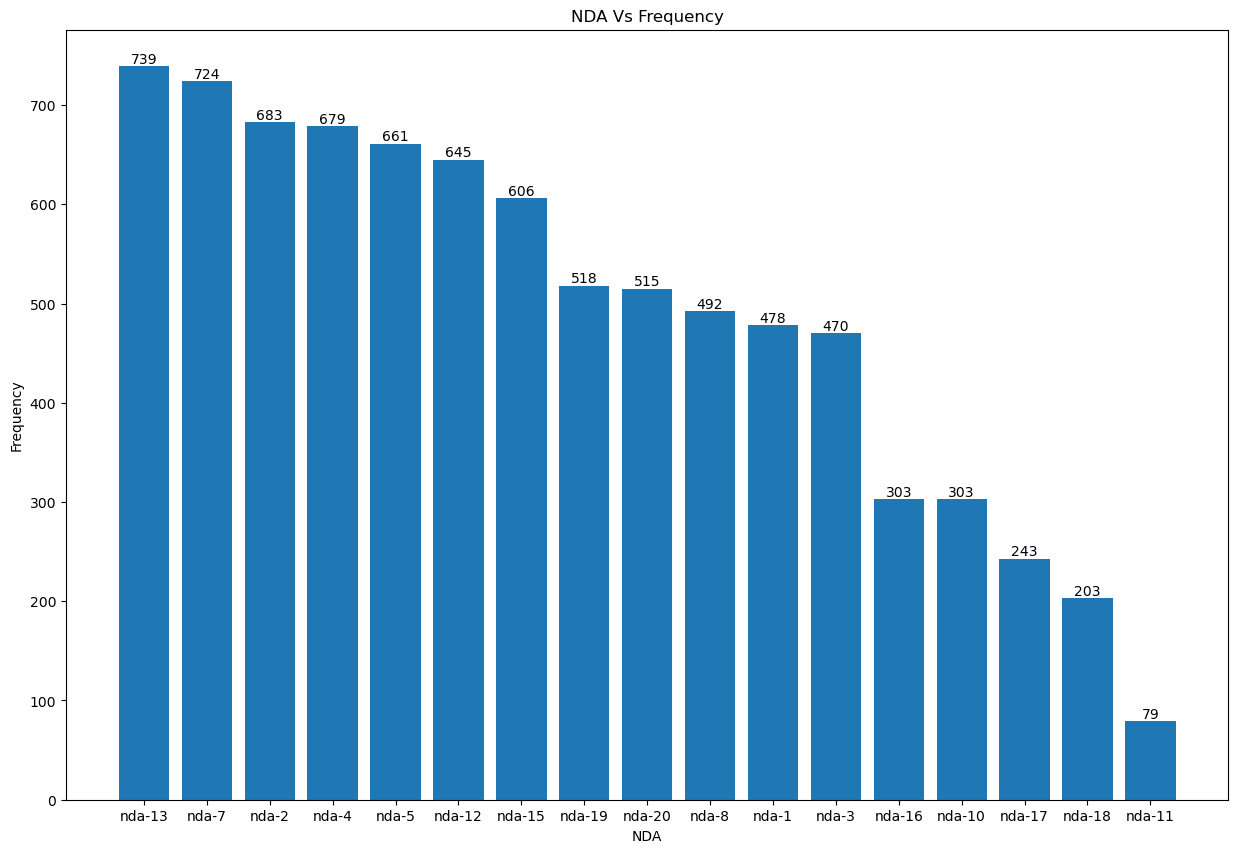

In [18]:
document_annotations = get_document_nda_counts()
nda_counts = get_total_nda_counts(document_annotations)
plot_nda_counts_bar(nda_counts)

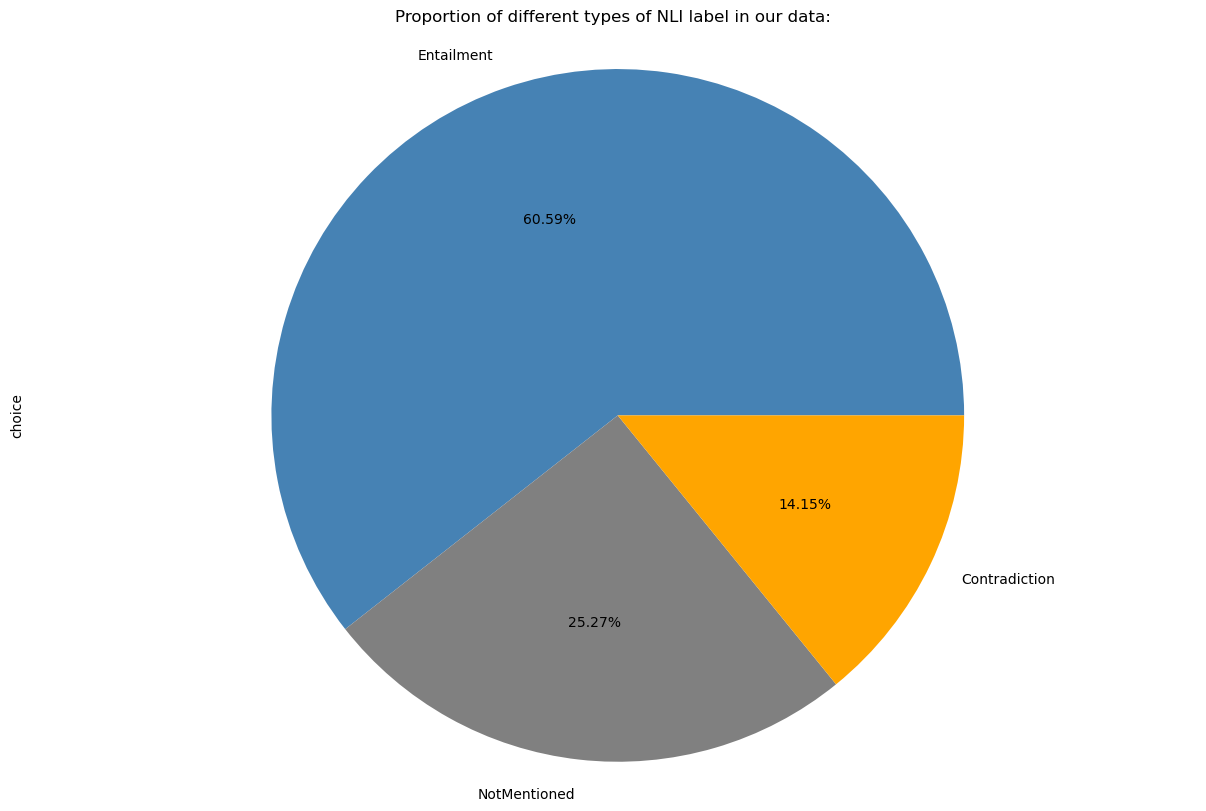

In [19]:
# NLI label pie chart
def plot_nli_label_pie(text_nda_df):
    plt.subplots(figsize=(15,10))
    text_nda_df['choice'].value_counts().plot.pie(colors = ['Steelblue', 'Gray', 'orange'], autopct='%1.2f%%')
    plt.axis('equal')
    plt.title("Proportion of different types of NLI label in our data: ")
    plt.show()

plot_nli_label_pie(text_nda_df)

In [20]:
text_nda_new_df.drop(['choice'], inplace = True, axis = 1)
text_nda_df

,text,nda
0,",,,,,IV. NO REVERSE ENGINEERING; WORK PRODUCT:...",nda-11
1,5. All Confidential Information in any form an...,nda-16
2,5. All Confidential Information in any form an...,nda-16
3,4. Nothing in this Agreement is to be construe...,nda-15
4,11. The Recipient shall not advertise or other...,nda-10
...,...,...
11156,2.3 Provided that the Recipient has a written ...,nda-5
11157,2.3 Provided that the Recipient has a written ...,nda-5
11158,The Recipient shall use the Confidential Infor...,nda-4
11159,The Recipient shall use the Confidential Infor...,nda-4


In [21]:
import string
def preprocess_text(text):
    # Remove leading and trailing spaces
    text = text.strip()
    # Convert to lowercase
    text = text.lower()
    # Replace punctuation with spaces
    text=text.translate(str.maketrans("", "", string.punctuation))
    # Remove extra spaces
    text=text.replace('”', '').replace('“','')
    text = ' '.join(text.split())
    return text

In [22]:
text_nda_df['text'] = text_nda_df['text'].apply(lambda x: preprocess_text(x))
text_nda_df['text'] = text_nda_df['text'].apply(lambda x: ' '.join(item for item in str(x).split(' ') if item not in stopwords))
text_nda_df

,text,nda
0,iv reverse engineering work product receiving ...,nda-11
1,5 confidential information form medium includi...,nda-16
2,5 confidential information form medium includi...,nda-16
3,4 nothing agreement construed granting recipie...,nda-15
4,11 recipient shall advertise otherwise make pu...,nda-10
...,...,...
11156,23 provided recipient written agreement follow...,nda-5
11157,23 provided recipient written agreement follow...,nda-5
11158,recipient shall use confidential information s...,nda-4
11159,recipient shall use confidential information s...,nda-4


In [23]:
sentences = text_nda_df.text.values.tolist()
sentences[0]

'iv reverse engineering work product receiving party shall reverseengineer analyze attempt duplicate otherwise attempt determine design method compiling samples prototypes products originating party except pursuant mutually acceptable written agreement executed parties 9 recipient agrees use confidential information transmitter part thereof design development manufacturing purposes purpose4 receiving party undertakes term agreement period five 5 years date expiry termination reversecompile reverseassemble reverseengineer confidential information part thereof unless directed disclosing party proven appropriate documentationneither party shall without written approval party publish copy use confidential information sole benefit recipient must hold confidence disclose reproduce distribute transmit reverse engineer decompile disassemble transfer form means purpose confidential information portion vendor shallv refrain reverse engineering decompiling disassembling software code disclosed ib

In [24]:
text_nda_df["nda_cat"] = text_nda_df["nda"].astype('category').cat.codes
text_nda_df

,text,nda,nda_cat
0,iv reverse engineering work product receiving ...,nda-11,2
1,5 confidential information form medium includi...,nda-16,6
2,5 confidential information form medium includi...,nda-16,6
3,4 nothing agreement construed granting recipie...,nda-15,5
4,11 recipient shall advertise otherwise make pu...,nda-10,1
...,...,...,...
11156,23 provided recipient written agreement follow...,nda-5,14
11157,23 provided recipient written agreement follow...,nda-5,14
11158,recipient shall use confidential information s...,nda-4,13
11159,recipient shall use confidential information s...,nda-4,13


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(text_nda_df.text).toarray()
labels = text_nda_df.nda_cat
features.shape

(11161, 49974)

In [31]:
from sklearn.model_selection import train_test_split

sentences = text_nda_df['text'].values
y = text_nda_df['nda_cat'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size = 0.25, random_state = 1000)

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

vectorizer = CountVectorizer()

X_train_counts = vectorizer.fit_transform(sentences_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [33]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [34]:
print(clf.predict(vectorizer.transform(["iv reverse engineering work product receiving party shall reverseengineer analyze attempt duplicate otherwise attempt determine design method compiling samples prototypes products originating party except pursuant mutually acceptable written agreement executed parties 9 recipient agrees use confidential information transmitter part thereof design development manufacturing purposes purpose4 receiving party undertakes term agreement period five 5 years date expiry termination reversecompile reverseassemble reverseengineer confidential information part thereof unless directed disclosing party proven appropriate documentationneither party shall without written approval party publish copy use confidential information sole benefit recipient must hold confidence disclose reproduce distribute transmit reverse engineer decompile disassemble transfer form means purpose confidential information portion vendor shallv refrain reverse engineering decompiling disassembling software code disclosed ibc vendor terms agreement except expressly permitted applicable lawd receiving party may reverse engineer decompile disassemble software disclosed receiving partythe confidant must reverse engineer decompile software included confidential information make unauthorised copies confidential information recipient agrees copy reverse engineer attempt derive composition underlying information structure ideas confidential information except otherwise expressly set forth agreement parties herein hold confidence disclose reproduce distribute transmit reverse engineer decompile disassemble transfer directly indirectly form means purpose trade secrets confidential information portion thereof party recipient decompile disassemble reverse engineer attempt reconstruct identify discover source code underlying ideas techniques algorithms confidential information means whatever except may specifically authorized advance discloser writing42 confidential information disclosed disclosing party recipient otherwise comes knowledge recipient acknowledged recipient –the recipient irrevocably unconditionally agrees undertakes434 decompile disassemble reverse engineer otherwise modify adapt alter vary whole part confidential informationrecipient agrees modify adapt translate duplicate disassemble reverse assemble reverse compile reverse engineer take similar action respect software provided discloser connection agreement purpose otherwise attempt discover underlying source code softwareto extent party receives software programs party receiving party entitled carry reverse engineering software programs parts thereof utilize software programs purposes clearly evidently disclosed received4 party shall hold trust confidence protect treat strictly secret confidential times information received party respect information party agrees itb shall keep secret shall use manipulate exploit information except purpose strict accordance purpose terms agreement25 recipient shall perform reverse engineering confidential information particular event disclosing party provides computer software andor hardware recipient confidential information recipient may directly indirectly disassemble decrypt electronically scan decompile derive source code confidential information otherwise reverse engineer attempt reverse engineer design function confidential informationrecipient agrees reverse engineer decompile disassemble prototypes software hardware tangible objects products provided hereunder embody confidential information discloserc recipient agrees shall alter modify adapt create derivative works translate deface decompile disassemble convert human readable form reverse engineer part materials provided access discloser412 sp use except permitted 3 disclose divulge copy reproduce publish circulate reverse engineer andor decompile otherwise transfer whether directly indirectly confidential information party person entity sp shall take steps may reasonably necessary prevent fps confidential information failing hands unauthorised persons entities2 party receiving proprietary informationd shall reverse engineer decompile disassemble product hardware software received partythe applicant shall use purposes reverse engineer disassemble decompile copy software objects embody confidential information transmit directly indirectly confidential informationwithout limitation foregoing prospective vendor shall cause permit reverse engineering proprietary information decompilation disassembly software programs part proprietary information receiving party attempt determine content structure otherwise reverse engineer decompile material sample hardware software provided access pursuant agreement except expressly provided section 3 agreement1 consideration disclosure proprietary information disclosing party receiving party hereby agrees iv copy reverse engineer proprietary information receiving party shalliv refrain reverse engineering decompiling disassembling software code andor prerelease hardware devices disclosed disclosing party receiving party terms agreement except expressly permitted applicable lawin consideration foregoing exchange disclosure confidential information ihis company undertakes relation ihis’ confidential informatione copy reproduce reverse engineer reduce writing part thereof except may reasonably necessary purpose copies reproductions reductions writing made shall property ihis3 participate systematic attempt recreate material memory following examinationneither affiliates alter decompose disassemble reverse engineer otherwise modify confidential information received hereunder relates research development intellectual property processes new product developments product designs formulae technical information patent information knowhow trade secrets company 32 consideration provision right use samples petrolube agrees321 analyze analyzed sample order determine chemical structure composition permit third parties samethe receiving party directly indirectly attempt reverse engineer decrypt disassemble decompile decipher reconstruct reorient circuit design algorithms logic program code disclosing party’s products models prototypes contain confidential information provided pursuant agreementthe receiving party undertakes use confidential information research technical analysis reverse engineering andor exploit purpose commercial gains manner whatsoeverin relation confidential information disclosing party receiving party undertakes f reverse engineer disassemble decompile prototypes software tangible objects embody disclosing partys confidential information provided disclosing partythe participant may alter modify andor disassemble confidential information merge confidential information existing information databases unless expressly permitted purposes prior written approval kwsheach party receiving party agrees wille decompile disassemble reverse engineer part confidential informationthe recipient shall protect safeguard confidentiality confidential information least degree care recipient would protect confidential information event less commercially reasonable degree care use confidential information permit accessed used purpose purpose including without limitation reverse engineer disassemble decompile design around confidential intellectual property disclose confidential information person entity except recipients representatives need know confidential information relation purpose informed obligations hereunder agree abide supplier shall decompile reverse engineer company products information resulting decompiling reverse engineering shall deemed confidential information companythe recipient iii agrees copy alter modify disassemble reverse engineer decompile materials unless permitted writing disclosing party copies authorized made identified belonging disclosing party marked confidential proprietary similar legend neither party shall attempt reverse engineer analyze disassemble cause reverse engineered analyzed disassembled product formulation process technology sample technology provided party either directly indirectly receiving party shall reverseengineer decompile disassemble software disclosed shall remove overprint deface notice copyright trademark logo legend notices ownership originals copies confidential information obtains disclosing party4 furthermore receiving party also agrees followingthat take necessary measures ensure confidential information copied duplicated distributed reverse engineered reproduced manner except needed completion aforementioned projectthe receiving party shall reverse engineer disassemble decompile prototypes software tangible objects embody disclosing party’s confidential information provided receiving party hereunder8 receiving party maximum extent permitted applicable law refrain disassembling decompiling software otherwise attempting reverse engineer design function confidential information master distributor agrees copy reverse engineer disassemble decompile otherwise reproduce product equivalent whole partrecipient may reverse engineer decompile disassemble product except extent restriction expressly prohibited applicable law 24 recipient shall reverse engineer decompile disassemble confidential information products samples containing confidential information provided however recipient may examine formfactors products samples sole purpose internally evaluating attempt disassemble otherwise reverse engineer confidential material recipient transfer confidential material company persons reason strictly prohibitedthe parties shall make use reverse engineering processes techniques similar means obtain additional information company information disclosed otherwise obtained party material party access granted date first writtend receiving party may reverse engineer decompile disassemble software disclosed receiving partypinetree shall copy duplicate replicate decompile reverse engineer manner whatsoever whether physically electronically writing otherwise whole part part proprietary information without prior written consent sti consent shall stis sole absolute discretion immediately notify sti writing unauthorized disclosure proprietary information receiving party shalliv refrain reverse engineering decompiling disassembling software code andor prerelease hardware devices disclosed disclosing party receiving party terms agreement except expressly permitted applicable lawreceiving party shall reverseengineer decompile disassemble software disclosed agreement shall remove overprint change notice including ownership confidentiality originals copies confidential informationneither party shall use confidential information received develop product service competes imitates products disclosing party engage reverse engineering develop similar products services using confidential information acknowledged understood parties engaged business beer brewing competing beer products regularly independently developed within beer industry using similar raw materials processes packaging 5 receiving party shall copy except reasonably required purpose alter modify disassemble reverse engineer decompile confidential information without prior written consent disclosing party event may receiving party reverse engineer decompile disassemble evaluation materials neither party shall reverse engineer patent around directly indirectly commercially exploit confidential information party use benefit others confidential information consists computer software disclosed object code form hardware device receiving party associates shall shall permit associates party reverse engineer decompile reverse compile disassemble object code take steps derive source code equivalent thereof2 without prior written consent party except otherwise provided herein neither company xplore b reverse engineer party’s information neither party shall reverse engineer disassemble decompile confidential information party prototypes software tangible objects embody confidential information party provided party hereunder evaluation material includes software object code form receiving party shall shall permit party reverse engineer reverse compile disassemble object code take steps derive source code equivalent thereof4 recipient agrees reverseengineer third party reverseengineer proprietary information without first obtaining express written consent discloserrecipient shall reverse engineer disassemble decompile prototypes software tangible objects embody company’s confidential information provided recipient hereunder"])))

[2]


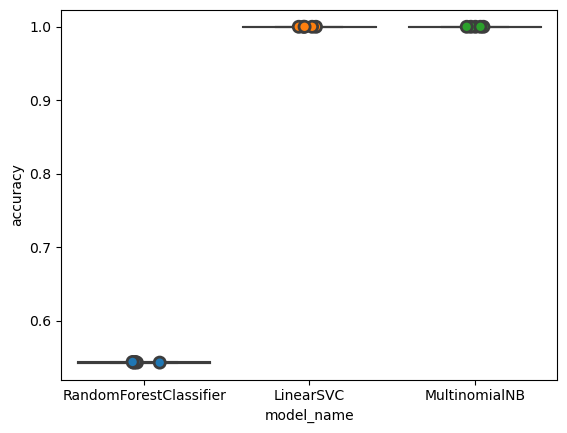

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import seaborn as sns

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB()
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [44]:
entries

[('RandomForestClassifier', 0, 0.5427675772503359),
 ('RandomForestClassifier', 1, 0.543010752688172),
 ('RandomForestClassifier', 2, 0.543010752688172),
 ('RandomForestClassifier', 3, 0.5439068100358423),
 ('RandomForestClassifier', 4, 0.5439068100358423),
 ('LinearSVC', 0, 1.0),
 ('LinearSVC', 1, 1.0),
 ('LinearSVC', 2, 1.0),
 ('LinearSVC', 3, 1.0),
 ('LinearSVC', 4, 1.0),
 ('MultinomialNB', 0, 1.0),
 ('MultinomialNB', 1, 1.0),
 ('MultinomialNB', 2, 1.0),
 ('MultinomialNB', 3, 1.0),
 ('MultinomialNB', 4, 1.0)]

In [48]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, text_nda_df.index, test_size=0.33, random_state = 43)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [49]:
y_pred

array([15, 14, 15, ...,  4, 11,  3], dtype=int8)

In [50]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

1.0
